In [2]:
# Karpathy says he pastes this as the top of every file
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

In [8]:
f(3.0)

20.0

[-5.   -4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25
 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75
  4.    4.25  4.5   4.75]


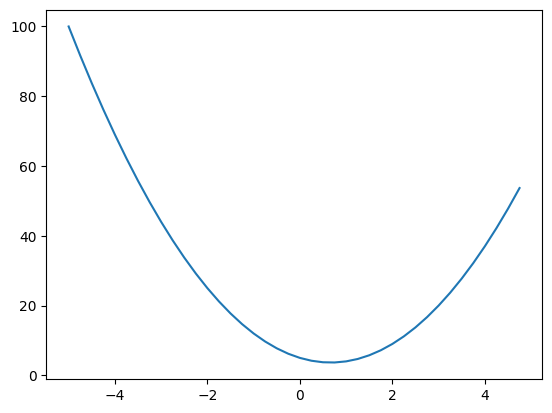

In [17]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
print(xs)
plt.plot(xs, ys)

In [18]:
# derivative review
h = 0.0001
x = 3.0
(f(x+h)-f(x))/h

14.000300000063248

In [19]:
# More complicated
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [21]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

# This is the rate of change of the function wrt. a, bumping a
# Checks out bc if you do partial differentiation 

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [26]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

# This is the rate of change of the function wrt. a, bumping a
# Checks out bc if you do differentiation wrt. a it's the same

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [596]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
    
  def __radd__(self, other): # other + self
    return self + other
  
  def __add__(self, other): # self + other
    # allow adding constant numbers to Value
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      # flow by chain rule
      # we know that: dOut/dSelf = 1 and dOut/dOther = 1 because this is addition (out = self + other)
      # we also know dL/dOut (out.grad)

      self.grad += 1.0 * out.grad # dL/dSelf = dL/dOut * dOut/dSelf
      other.grad += 1.0 * out.grad # dL/dOther = dL/dOut * dOut/dOther
    out._backward = _backward
    
    return out

  def __neg__(self): # -self
        return self * -1
  
  def __sub__(self, other): # self - other
    negation = -other
    return self + negation

  def __rmul__(self, other): # other * self
        return self * other;

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      # mul: out = self * other
      # know: dOut/dSelf = other.data, dOut/dOther = self.data, dL/dOut = out.grad
      self.grad += out.grad * other.data # dL/dSelf = dL/dOut * dOut/dSelf = out.grad * other.data
      other.grad += out.grad * self.data # dL/dOther = dL/dOut * dOut/dOther = out.grad * self.data
    out._backward = _backward
      
    return out

  def __truediv__(self, other):
        return self * other**-1
    
  # n = other, self = x
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward(): # suppose we know dL/dOut, how to calc dL/dX: dL/dOut * dOut/dX
            self.grad += out.grad * out.data
        out._backward = _backward
        
        return out
  
  def tanh(self):
    # right out of https://en.wikipedia.org/wiki/Hyperbolic_functions
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      # know: dL/dOut = out.grad
      # o = tanh(n)
      # AND do/dn = 1 - tanh(n)^2 = 1 - o^2
      # now apply chain rule: 
        
      # want: dL/dn
      # dL/dn = dL/dOut * do/dn = out.grad * 1 - o^2
      self.grad += out.grad * (1 - t**2)
    out._backward = _backward
    
    return out
  
  def backward(self):
    # build a topological graph starting at self
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo): # starting at self go back
      node._backward()


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L' # output of our graph
L

Value(data=-8.0)

In [593]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [594]:
# What the grad (gradient) represents is the dL/dX where X is the current node. 
# The derivative of L with respect to X
# AKA: How much does L change when X changes

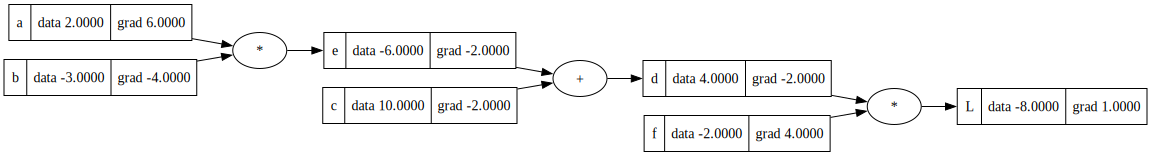

In [599]:
draw_dot(L)

In [276]:
# How do we calculate dd/dc ? should be 1.0 because d = e + c
# The question is how to calc dL/dc.

# WANT:
# dL/dc

# KNOW:
# dL/dd
# dd/dc

# THEN: (by chain rule)
# dL/dc = (dL/dd) * (dd/dc)

# + Nodes just route the gradient through because this local derivative dL/dd is always 1
# Then dL/dc = dL/dd = -2.0

# Now for dd/db

# KNOW:
# dL/de = -2.0
# de/db = a (because a*b = e)

# THEN:
# dL/db = dL/de * de/db = -2.0 * a = -2a


In [598]:
# Manual backprop
L.grad=1.0
f.grad = 4.0
d.grad = -2.0
e.grad = d.grad
c.grad = d.grad
b.grad = d.grad * a.data
a.grad = d.grad * b.data

In [278]:
# Suppose we want L to go up. Then we should move our values in the direction of the gradient.
# We can typically only change the values at the beginning
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# Do a forward pass
e = a*b
d = e + c
L = d * f

print(L.data) # we expect this to go up since we nudged all the values in the direction of the gradient

-7.286496


### The grad represents the derivative of the output with respect to the node

# define a function so as not to pollute the global scope. 
# use this to manually check the derivative of L wrt to some node
def lol():
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L' # output of our graph
    L1 = L.data
    
    
    
    # adding h
    a = Value(2.0, label='a')
    b = Value(-3.0+h, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L' # output of our graph
    L2 = L.data
    
    print((L2 - L1)/h)
    
lol()

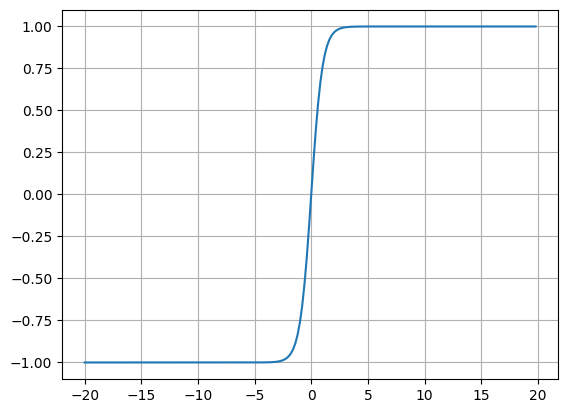

In [112]:
# Squashing function tanh
# Very pos/neg inputs get capped at -1 or 1 respectively
r = np.arange(-20, 20, 0.2)
plt.plot(r, np.tanh(r))
plt.grid()



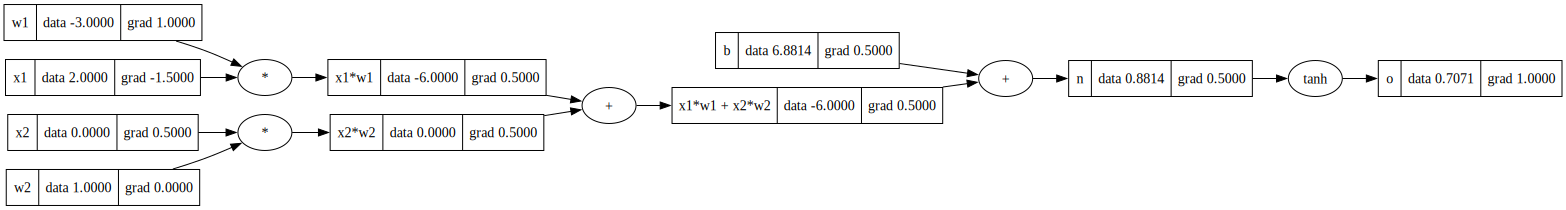

In [600]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n' # n is the cell body without activation function
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

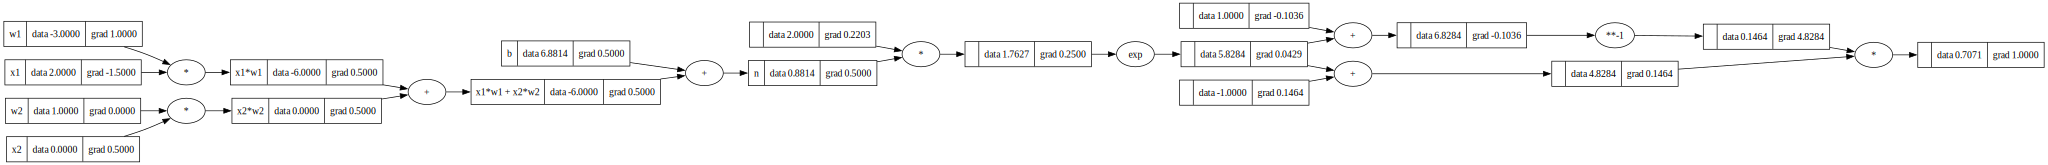

In [370]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n' # n is the cell body without activation function

## alternate tanh
e2x = (2*n).exp()
o = (e2x - 1)/(e2x + 1)
o.backward()
draw_dot(o)

In [363]:
# A bug
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()

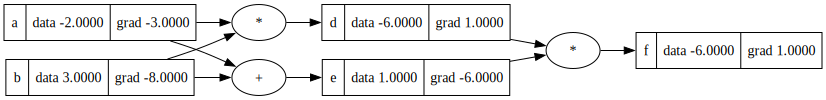

In [264]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

In [326]:
a = Value(2.0) + 3
a = a * 3
a / 3



Value(data=5.0)

In [184]:
# Do manual backprop

o.grad = 1.0 # base case

# How do we calculate the derivative of tanh?
# If o = tanh(n)
# What is do/dn

# Per wikipedia
# do/dn = 1 - tanh(n)^2 = 1 - o^2

n.grad = 1 - o.data ** 2 # 0.5

# + means flow
x1w1x2w2.grad = n.grad
b.grad = n.grad

x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

# * means scale the gradient by the other factor
x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data

x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data




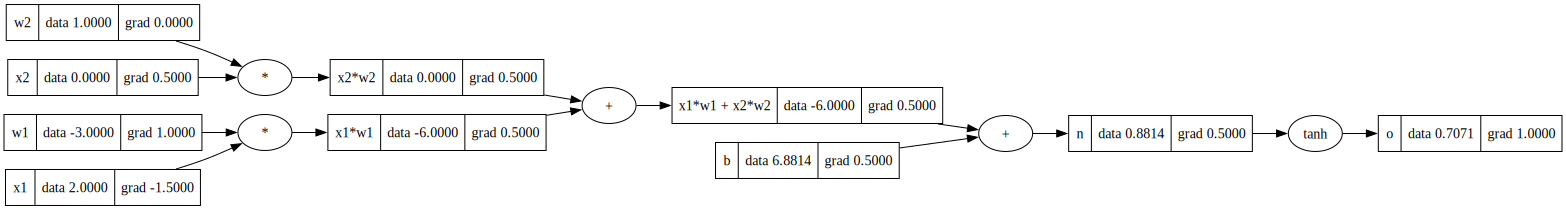

In [609]:
# Micrograd

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n' # n is the cell body without activation function
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

In [392]:
# Introduce pytorch

import torch

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item()) # item just pops the scalar value out of a single value tensor
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


weights  [Value(data=-0.30234310098601)]
biases  Value(data=-0.6707743111609417)
result  Value(data=-0.9748894501896991)


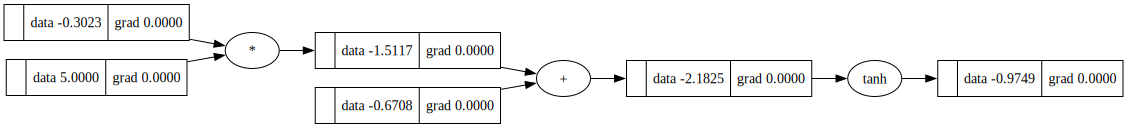

In [508]:
import random

class Neuron:
  
  def __init__(self, nin): #nin = # of inputs for the neuron (nin-dimensional neuron)
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b (dot product of wx + b)
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):  #nout = # of neurons in the layer
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
#     print(sz)
    # Start building from the second layer, which takes the first layer as input
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


# 1D Neuron
x = [5]
n = Neuron(1)


print('weights ', n.w)
print('biases ', n.b)

result = n(x)
print('result ', result)
draw_dot(result)

weights  [Value(data=0.8323288869442769), Value(data=0.8665485833978528), Value(data=-0.9813311568021197)]
biases  Value(data=-0.1568879677060604)
result  Value(data=-0.48954016054169486)


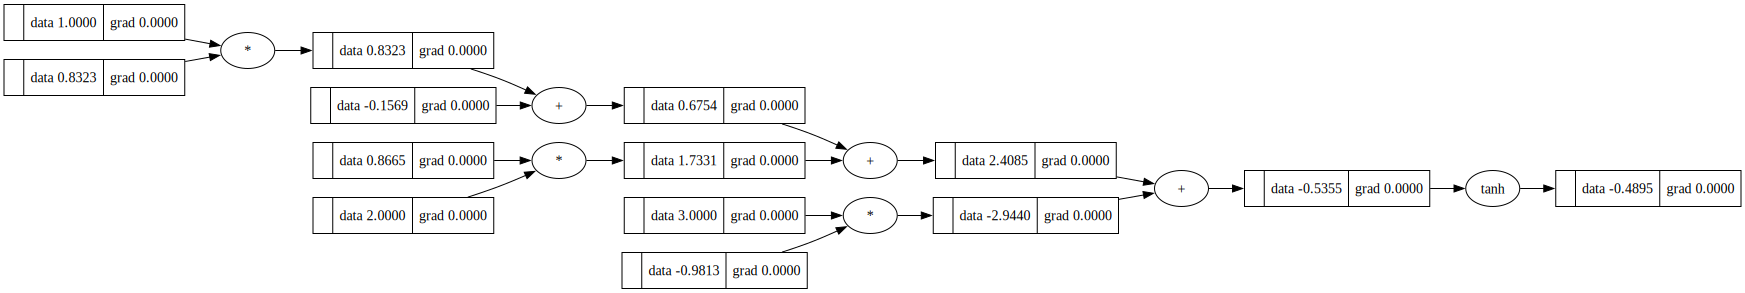

In [509]:
# 3D Neuron
x = [1,2,3]
n = Neuron(3)


print('weights ', n.w)
print('biases ', n.b)

result = n(x)
print('result ', result)
draw_dot(result)

weights: [[Value(data=-0.473100275815566), Value(data=-0.6825302870154688), Value(data=-0.024256436731221243)], [Value(data=0.12648729149882354), Value(data=-0.02752060493094577), Value(data=-0.8995771023104735)], [Value(data=0.6167317299803909), Value(data=0.877069685028542), Value(data=-0.948011950775618)], [Value(data=0.5444423048777762), Value(data=0.04496394903022005), Value(data=0.45191500814142427)]]
biases: [Value(data=-0.9762333364648139), Value(data=-0.3604430809602477), Value(data=0.14765226747174975), Value(data=-0.32661439722150165)]
result  [Value(data=-0.9938066632674585), Value(data=-0.9949321902292938), Value(data=-0.31448280010631724), Value(data=0.9306871981871769)]


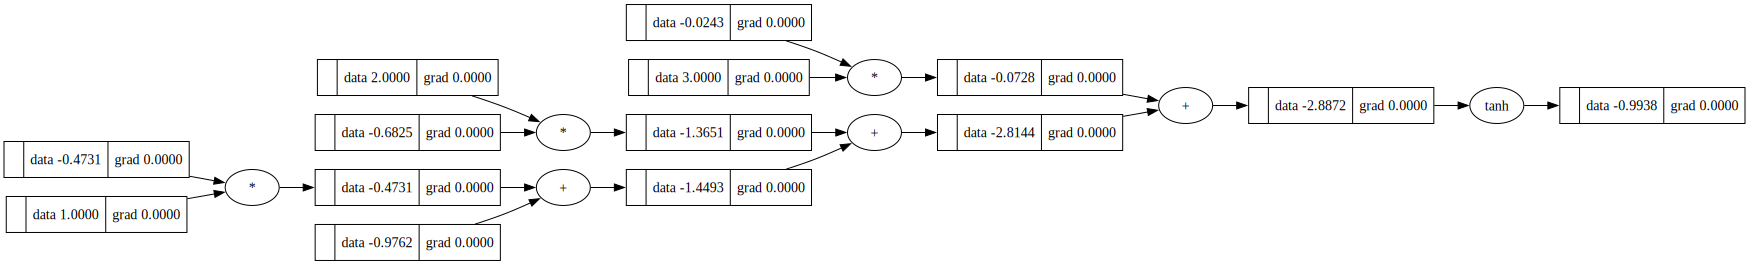

In [510]:
# 4-neuron size layer of 3d neurons
x = [1,2,3]
l = Layer(3, 4)


print('weights:', [n.w for n in l.neurons])
print('biases:', [n.b for n in l.neurons])

result = l(x)
print('result ', result)
draw_dot(result[0]) # one of the neuron in the layer's outputs

Value(data=0.5965855866847377)


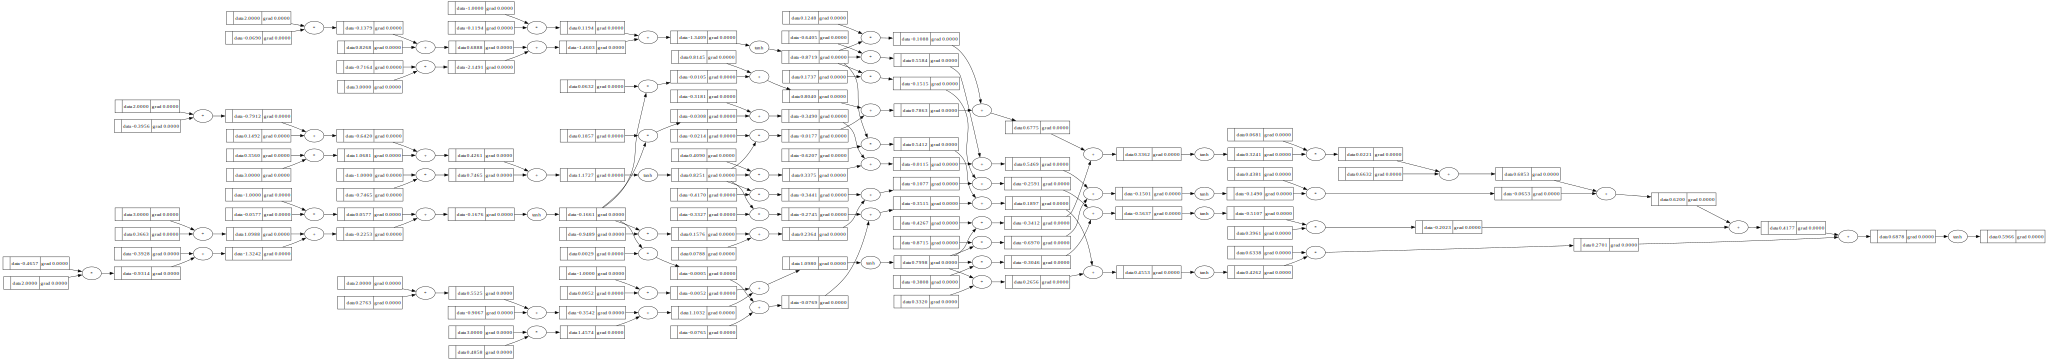

In [664]:
# Reimplement this: https://cs231n.github.io/assets/nn1/neural_net2.jpeg

# NOTE: input layer does not count
x = [2.0, 3.0, -1.0] # 3D input


n = MLP(3, [4, 4, 1]) # 3 inputs into 2 layers of 4 and 1 output

res = n(x)

print(res)
draw_dot(res)

In [665]:
# Using the MLP from last time

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
] # dataset of four examples, 

# We want neural net to output 1.0 for first example, -1.0 for second, etc.
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

# This is what the neural net currently thinks about this
ypred = [n(x) for x in xs]
ypred

[Value(data=0.5965855866847377),
 Value(data=0.4486214140127745),
 Value(data=0.6718306092232619),
 Value(data=0.4658755293607727)]

In [615]:
# loss is a single number that calculates how well the neural network is performing

# mean squared error loss
# error -> difference between target and output
# square -> makes positive
# these qualities make it: if your prediction is the target, you get loss 0, otherwise, you get some positive 
# number proportional to how wrong you were


results = [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]
print(results)

loss = sum(results)
loss




[Value(data=2.607194361397897), Value(data=0.17545002846933824), Value(data=0.04983548545450101), Value(data=2.834075477273096)]


Value(data=5.666555352594832)

In [670]:
# Gradient Descent 1
# Recalc loss after training - forward pass

ypred = [n(x) for x in xs] # recalc preds
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=0.011934012955273843)

In [657]:
# Gradient Descent 2
# something magical happens - backward pass
loss.backward()

In [658]:
# Gradient Descent 3
# Nudge
# print(n.layers[0].neurons[0].w[0].grad) # gradient = neg -> increasing this neuron means decreasing loss
# print(n.layers[0].neurons[0].w[0])

for p in n.parameters():
    p.data += -0.1 * p.grad

# print(n.layers[0].neurons[0].w[0].grad) # back prop went all the way back here
# print(n.layers[0].neurons[0].w[0])

In [671]:
# target = [1, -1, -1, 1]
ypred

[Value(data=0.9693033387185176),
 Value(data=-0.9652196989098),
 Value(data=-0.9279370358037952),
 Value(data=0.9322579319124717)]

In [669]:
# automatated loop

for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass (zero grad) common mitakes
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.05 * p.grad
  
  print(k, loss.data) # print step and loss
  

0 0.01927626941769224
1 0.018712547084405028
2 0.01817950122172931
3 0.01767474000033655
4 0.017196111242809873
5 0.01674167336306271
6 0.016309670411500124
7 0.015898510567569888
8 0.015506747538892718
9 0.015133064420673638
10 0.01477625964547604
11 0.014435234715461424
12 0.014108983459792467
13 0.013796582601351748
14 0.013497183451037306
15 0.013210004576074737
16 0.01293432531215614
17 0.012669480008667031
18 0.012414852912517621
19 0.012169873609715031


In [666]:
ypred

[Value(data=0.5965855866847377),
 Value(data=0.4486214140127745),
 Value(data=0.6718306092232619),
 Value(data=0.4658755293607727)]